# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

**1. Download assignment 1 from Stanford's CS231n:**

Assignment folder is downloaded from the given link. Then, knn.ipynb is launched with jupyter-notebook.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**2. Download and extract CIFAR-10 dataset using get_datasets.sh script under cs231n/datasets .**

get_datasets.sh bash script is used to install the data and extract it from the tar.gz with wget and tar commands. At final, it removes the tar.gz with rm command, since it is not required anymore.

**3. Start notebook with jupyter-notebook command. In the notebook, run library/parameter setups
and load CIFAR10 dataset . You should have output like
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)**

As can be seen below, running written codes without changing anything resulted as expected output.
The load_CIFAR10() function requires the path of the downloaded dataset. It reads data from batches and then concatenate all these batches at x and y. Lastly, reads test batch and returns train and test data.

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


**4. Run visualizing part and see your images and classes.**

As it is given below, CIFAR_10 dataset has 10 classes. In order to visualize the classes randomly indexes are selected for each class. Afterwards, examples of each class is shown at plot with respect to determined samples_per_class variable.

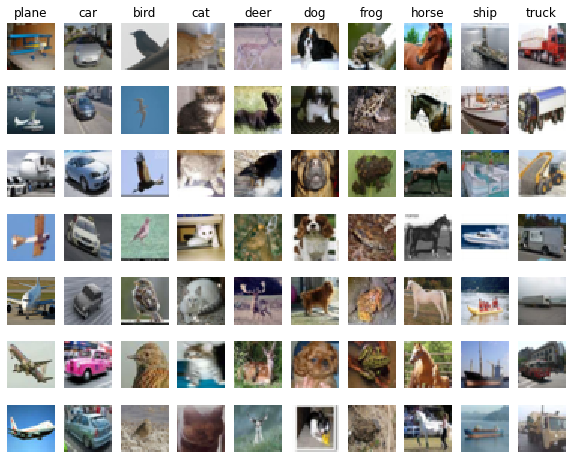

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Gets number of classes
num_classes = len(classes)

# Number of how much example will be given for each class.
samples_per_class = 7

for y, cls in enumerate(classes):
    # gets indexes of the class
    idxs = np.flatnonzero(y_train == y)
    
    # Randomly picks images from obtained indexes
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    # Plots each class with title of the class
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**5. Subsample your data with 5000 training samples and 500 test samples**

In order to subsample the data index list is generated which starts from 0 to number of data to be sampled. For this example, training images will be sampled to 5000 and test images will be sampled to 500. Even though this sampling works, the selection is not random and if data classes were seperated from each other this subsample would be imbalanced dataset. Even some classes may not be seen at the training step. Therefore, numpy random choice may work better at subsampling the dataset.

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


**6. Initialize KNearestNeighbor class and train your dataset. Remember that training is just saving the
dataset as variables.**

K-Nearest Neighbor algorithm working principle is storing all training data into memory and comparing the test data with respect to each train image. In comparison step, L1, L2 or different distance metrics can be used. Because of the working principle, k-NN training time is pretty short. However, test consumption time increases with respect to training size because of the comparison.

In [5]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

**7. Implement compute_distances_two_loops function in cs231n/classifiers/k_nearest_neighbor.py that
computes Euclidean distance (L2 distance/norm) between test and training samples. Call this
function from notebook.**



Eucledian distance (L2 distance/norm) calculates distance between given points or arrays. In this case, inputs are two different arrays which represent train and test images. In order to calculate distance between two image, each data point is subtracted from the matched data point. Then, square of all distance will be summed. At final, square root of the sum will be taken to obtain final distance between two images. Mathematical formula of the L2 distance is:

$\sqrt{\sum _{i=1}^n (x_i-y_i)^2}$

In [6]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


**8. Plot the Euclidean distance matrix between the training and the test set. Describe the plot.
(Answer inline question 1)**

The Euclidean distance matrix shows the distances between training and test images. Test images are rows and train images are the columns. Each pixel shows the distance between given train and test image. The higher the distance the brighter pixel. Similarly, The lower the distance is the darker pixel. 

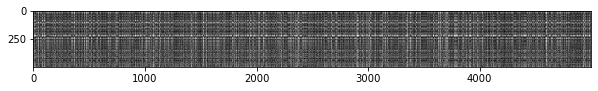

In [7]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$
* Since the white pixel represents that test image and train image is not close to each other, distincly bright rows shows that test image is not similiar with any train images.
* Columns represent the distance between the specific train image and all test images. If a column is distincly brigth it shows that train image is not similar with any test images. On the other hand, distincly black column shows that train image is similar with most of test images.

**9. Implement predict_labels function and calculate the accuracy of your classifier.**

Prediction step, predicts the given inputs with respect to training images. Thus, accuracy can be calculated by comparing predictions and ground truths of the data. Formula of the accuracy is:

$Accuracy = \frac{\text{Number  of correct predictions}}{\text{Number  of  total  predictions}}$

Additionally, in order to eliminate failure prediction cases of same count of class prediction from neighbors when k > 1. Distances are considered priorly when at least 2 count of neighbor is same. In order to explain it more clearly an example given below.

Assuming k=5 and 5 closest neighbor of the test image is [6, 6, 4, 4, 5]. Here can be seen, count of class of 6 and class of 4 is same. If we were only using argsort and argmax algorithm with bincount 4 would be prioritized because of index of it is smaller than 6. However, class 6 is more close to the given input than the class 4. That is why, distances are considered when this type of case occur at prediction.

In [8]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [9]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 144 / 500 correct => accuracy: 0.288000


You should expect to see a slightly better performance than with `k = 1`.

**10. Answer inline question 2. (in the 5th step, answer theoretically)**

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$ 1,2,3,4

$\color{blue}{\textit Your Explanation:}$
1. Subtracting the mean from each image will not change the distance between any image matches. The reason of it is because of we are subtracting same values from both of the images. Theoretically, $\sum_{i=1}^n |x_i - y_i| = \sum_{i=1}^n| (x_i-μ) - (y_i-μ)|$ as can be seen subtracting mean from both images are cancelling each other.
2. Similarly to first answer removing same values from both pixels will not result any change. It is just shifting pixel values in coordinate system. Theoretically, $\sum_{i=1}^n |x_i - y_i || = \sum_{i=1}^n |(x_i - μ_i) - (y_i - μ_i)||$ μ_i values are cancelling each other at here too.
3. As I explained in the first answer subtracting means will not result in any differ between distances. Additionally dividing by the standard deviation will change distance results but class predictions will still remain same. It is just like normalizing the values. Mathematical expression of it is $\sum_{i=1}^n |x_i - y_i| != \sum_{i=1}^n | \frac{x_i - μ}{\sigma} - \frac{y_i - μ}{\sigma} |$. In practice results may differ slightly when the variable can not hold required floating points. Yet, theoretically results will not change.
4. Subtracting pixel-wise mean is just shifting the pixel values and dividing pixel-wise standard deviation will change distances but not predictions. Since this case similar to 3rd question equation of it is, $\sum_{i=1}^n |x_i - y_i|  != \sum_{i=1}^n |\frac{(x_i - μ_i)}{\sigma_i} - \frac{(y_i - μ_i)}{/\sigma_i} |$
5. Rotating the array will result differently in different points. In order to explain it more mathematically an example is given below. By assuming we just have 2D data point this rotation matrix will be used.

$\begin{bmatrix}
x'\\
y'
\end{bmatrix}
= \begin{bmatrix}
cos\theta & -sin\theta\\
sin\theta & cos\theta
\end{bmatrix}
\begin{bmatrix}
x\\
y
\end{bmatrix}
$

For instance our data points are $x1 = (20, 43)\\ x2 = (50, 85)$ if we just rotate 45° their new points is calculated as below.
$\\\begin{bmatrix}
\frac{-23}{\sqrt{2}}\\
\frac{63}{\sqrt{2}}
\end{bmatrix}
= \begin{bmatrix}
cos(45°) & -sin(45°)\\
sin(45°) & cos(45°)
\end{bmatrix}
\begin{bmatrix}
20\\
43
\end{bmatrix}
$

$\begin{bmatrix}
\frac{-35}{\sqrt{2}}\\
\frac{135}{\sqrt{2}}
\end{bmatrix}
= \begin{bmatrix}
cos(45°) & -sin(45°)\\
sin(45°) & cos(45°)
\end{bmatrix}
\begin{bmatrix}
50\\
85
\end{bmatrix}
$

L1_distance of default points of x1 and x2 is equal to $| 20 - 50 | + | 43 - 85 | = 72$

However, L1 distance of rotated points of x1 and x2 is equal to $|\frac{-23}{\sqrt{2}} - (\frac{-35}{\sqrt{2}})| + |\frac{63}{\sqrt{2}} - \frac{135}{\sqrt{2}}| = 42\sqrt{2}$

These equations explain how rotation results varies with respect to input data. Because of this variation L1 distance between two pixel will result differently at each comparison, so the performance of k-NN most probably decrease.

**11. Implement compute_distances_one_loops and compute_distances_no_loops functions. Call these
from notebook. Compare all three implementations by their execution time.**

One loop function calculates distances between each test image and train batch at the same time. Thus, all distances will be assigned to relevant row of the test image.

Idea of the no loop function is to running all comparison at the same time. However, subtracting two different sized array is not possible. That is why, instead of using default $(x - y)^2$ the equation is expanded as $x^2 -2xy +y^2$. Since last equation is required to be shaped as (500, 1) $sum(x^2)$ (train images) are reshaped as (1,5000). Matrix multiplication is done as $y * x.T$ The reason of obtaining transpose of train images is to obtain array shaped as (500, 5000). Test images are also shaped as (500, 1) after the $sum(y^2)$ equation. At the final, all these equations are added and squareroot of their result is obtained to generate final distance results.

In [10]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [11]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 35.179939 seconds
One loop version took 51.915745 seconds
No loop version took 0.279313 seconds


**12. Perform cross-validation with the training set split in 5 folds, and assert the best k=[1, 3, 5, 8, 10,
12, 15, 20, 50, 100]. Plot the cross-validation accuracy vs. k. Evaluate the number of correct
predictions for the test set by using the best k.**

Cross validation algorithm divides training data with respect to defined number of folders. It trains defined model number of folders times, each time excluding one folder and training the remaining ones. Then, validation results are evaluated for each folder. Finally, best k is determined by the average of the validation results for each k. 

As a result of evaluation best_k will be 8.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [13]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train_folds = np.array(np.array_split(X_train, num_folds))
y_train_folds = np.array(np.array_split(y_train, num_folds))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
for k in k_choices:
    k_to_accuracies[k] = [0.0 for i in range(num_folds)]   

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Best accuracy is defined to find best k.
best_accuracy = 0.0
for k in k_choices:
    for i in range(num_folds):
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]
        
        train_fold_indexes = [j for j in range(num_folds) if i != j]
            
        X_train_fold = X_train_folds[train_fold_indexes]\
                        .reshape((num_folds -1) * X_val_fold.shape[0], X_val_fold.shape[1])
        y_train_fold = y_train_folds[train_fold_indexes]\
                        .reshape((num_folds -1) * y_val_fold.shape[0],)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        
        dists = classifier.compute_distances_no_loops(X_val_fold)
        y_val_pred = classifier.predict_labels(dists, k=k)
        
        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_val_pred == y_val_fold)
        k_to_accuracies[k][i] = float(num_correct) / len(y_val_pred)
    
    # In order to 
    avg_accuracy = sum(k_to_accuracies[k]) / len(k_to_accuracies[k])
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_k = k
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.263000
k = 5, accuracy = 0.274000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.297000
k = 5, accuracy = 0.288000
k = 8, accuracy = 0.271000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.301000
k = 8, accuracy = 0.291000
k = 10, accuracy = 0.270000
k = 10, accuracy = 0.305000
k = 10, accuracy = 0.288000
k = 10, accuracy = 0.295000
k = 10, accuracy = 0.286000
k = 12, accuracy = 0.268000
k = 12, accuracy = 0.304000
k = 12, accuracy = 0.286000
k = 12, accuracy = 0.290000
k = 12, accuracy = 0.276000
k = 15, accuracy = 0.259000
k = 15, accuracy = 0.307000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.294000
k = 15, accuracy = 0.281000
k = 20, accuracy = 0.267000
k = 20, accu

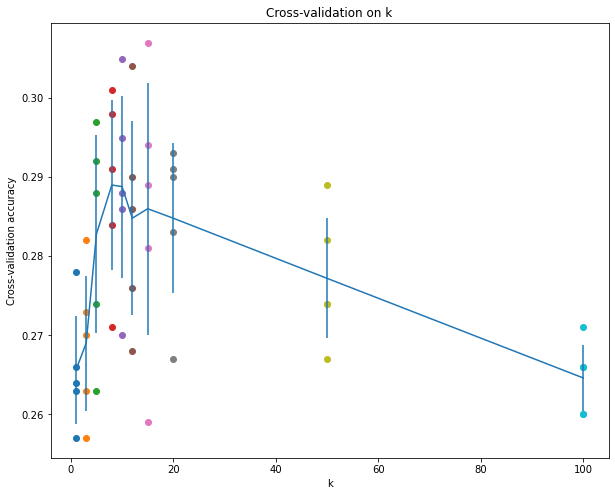

In [14]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [15]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.

# best_k is determined with the evaluation of each k at cross validation section.
# It is determined as 8 from the evaluation.
#best_k = 1

# k-NN is initialized
classifier = KNearestNeighbor()
# train data is loaded to RAM
classifier.train(X_train, y_train)
# test data is predicted
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 148 / 500 correct => accuracy: 0.296000


**13. Answer inline question 3.**

**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$
2, 4

$\color{blue}{\textit Your Explanation:}$
1. Since boundary of k-NN varies with respect to k, it does not simply differentiates classes like below the line or above the line. It varies with  Thus, decision boundary of the k-NN classifier is not linear. Also boundary for 3 classed k-NN can be seen at the explanation of 3rd answer.
2. Training error of a 1-NN will always be lower than or equal to 5-NN because of the image that will be tested has identical one inside the training set. That is why their distance will be 0.0. Thus, training error of 1-NN will always be 0% which means it will always be lower than or equal to 5-NN.
3. Test errors of of a 1-NN and 5-NN varies with respect to distribution of the data. A test image may closest to plane in 1-NN but it may predicted as horse at 5-NN. For this reason, it is not always true that 1-NN test error will be less than 5-NN test error. In order to understand more clearly image can be examined below.
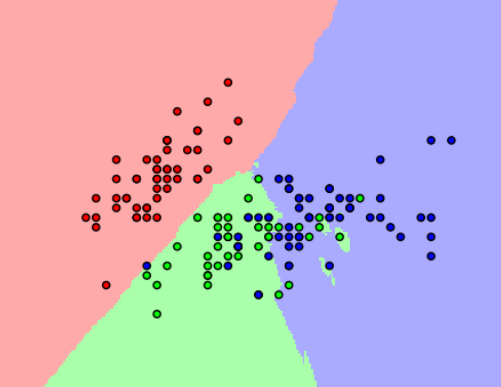
4. Because of at testing step, all test images are compared with the train images. Increasing size of the training set will result in requirement of more comparison. Therefore, the time needed to classfiy test example will increase with respect to train size.